In [1]:
import pandas as pd
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, Normalize


import json
import os
from datetime import datetime

from utils import running_mean

import seaborn as sns
sns.set_style("whitegrid")

# mpl.use('pdf')
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)

IMAGEDIR = "./images/scratch/"
DRYRUN = True
OPEN_SAVEDIMAGES = False
BURN_IN_PROP = 0.9

if not DRYRUN:
    os.makedirs(IMAGEDIR, exist_ok=True)

def _generate_filepath(name):
    filepath = os.path.join(IMAGEDIR, name)
    print(f"Saving file at: {filepath}")
    if os.path.exists(filepath):
        print(f"Warning: Overwriting existing file: {filepath}")
    return filepath

def savefig_fn(fig, name):
    filepath = _generate_filepath(name)
    if not DRYRUN:
        fig.savefig(filepath, bbox_inches="tight")
        if OPEN_SAVEDIMAGES:
            os.system(f"open {filepath}")
    else:
        print("DRY RUN, figure not saved.")
    return


# Query Database and Parse Data

In [2]:
# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['test_dln_stagewise_learning']
collection = db['runs']

EXPT_NAME = "test_run"

_to_array = lambda x: np.array(x)
COLUMN_TRANSFORM = {
    "component_potential_grad_norm": _to_array,
    "corrected_total_matrix": _to_array,
    "total_matrix": _to_array,
    "potential_matrix": _to_array,
}


query = {
    # "config.expt_name": EXPT_NAME, 
    # "status": "COMPLETED", 
    # "_id": 24 # init origin
    # "_id": 29 # init away from origin 
    "_id": 46
}
expt_config = collection.find_one(query)["config"]
expt_properties = collection.find_one(query)["info"]["expt_properties"]


def parse_sgd_logs(logs):
    print("Parsing SGD logs...")
    eval_names = logs["eval_list"]
    other_cols = None
    data = []
    for checkpoint in logs["checkpoint_logs"]:
        keys = sorted(checkpoint.keys())
        keys.remove("evals")
        if other_cols is None:
            other_cols = keys
        else:
            assert keys == other_cols
        checkpoint_data = [
            checkpoint[key] for key in keys
        ] + checkpoint["evals"]
        data.append(checkpoint_data)
    columns = other_cols + eval_names
    df = pd.DataFrame(data, columns=columns)
    print(f"Columns: {columns}")
    print(f"Data shape: {df.shape}")
    # apply COLUMN_TRANSFORM
    for k, v in COLUMN_TRANSFORM.items():
        if k in df.columns:
            df[k] = df[k].apply(v)
    return df

def parse_gd_logs(logs):
    print("Parsing GD logs...")
    eval_names = logs["eval_list"]
    other_cols = None
    data = []
    for checkpoint in logs["checkpoint_logs"]:
        keys = sorted(checkpoint.keys())
        keys.remove("evals")
        if other_cols is None:
            other_cols = keys
        else:
            assert keys == other_cols
        checkpoint_data = [
            checkpoint[key] for key in keys
        ] + checkpoint["evals"]
        data.append(checkpoint_data)
    columns = other_cols + eval_names
    df = pd.DataFrame(data, columns=columns)
    print(f"Columns: {columns}")
    print(f"Data shape: {df.shape}")
    for k, v in COLUMN_TRANSFORM.items():
        if k in df.columns:
            df[k] = df[k].apply(v)
    return df



def parse_individual_stagewise_gd_logs(logs):
    eval_names = logs["eval_lists"]
    num_stages = logs["num_stages"]
    if num_stages != len(logs["stage_logs"]):
        print("Warning: num_stages does not match the number of stage logs.")
    other_cols = None
    data = []
    accumuated_time = 0
    for stage, stage_logs in enumerate(logs["stage_logs"]):
        for checkpoint in stage_logs:
            keys = sorted(checkpoint.keys())
            keys.remove("evals")
            if other_cols is None:
                other_cols = keys
            else:
                assert keys == other_cols
            checkpoint_data = (
                [checkpoint[key] for key in keys] 
                + checkpoint["evals"] 
                + [stage, num_stages, checkpoint["t"] + accumuated_time]
            )
            data.append(checkpoint_data)
        accumuated_time += stage_logs[-1]["t"]
    columns = other_cols + eval_names + ["stage", "num_stages", "total_time"]
    df = pd.DataFrame(data, columns=columns)
    print(f"Columns: {columns}")
    print(f"Data shape: {df.shape}")
    for k, v in COLUMN_TRANSFORM.items():
        if k in df.columns:
            df[k] = df[k].apply(v)
    return df

def parse_stagewise_gd_logs(logs):
    print("Parsing Stagewise GD logs...")
    results = {}
    for potential_type, potential_logs in logs.items():
        print(f"Parsing GD logs for stagewise potential type: {potential_type}")
        results[potential_type] = parse_individual_stagewise_gd_logs(potential_logs)
    return results

df_sgd = parse_sgd_logs(collection.find_one(query)["info"]["sgd_logs"])
df_gd = parse_gd_logs(collection.find_one(query)["info"]["gd_logs"])
stagewise_dfs = parse_stagewise_gd_logs(collection.find_one(query)["info"]["stagewise_gd_logs"])

Parsing SGD logs...
Columns: ['corrected_total_matrix', 'est_total_rank', 't', 'total_matrix', 'train_loss', 'true_lambda', 'true_multiplicity', 'full_potential', 'potential_matrix', 'total_potential_grad_norm', 'component_potential_grad_norm', 'stage_potential=block', 'stage_potential=diag', 'stage_potential=col', 'stage_potential=row', 'stage_potential=corner', 'stage_potential=offdiag_inclusive', 'stage_potential=offdiag_exclusive', 'stage_potential=row_col']
Data shape: (556, 19)
Parsing GD logs...
Columns: ['loss', 't', 'total_matrix', 'full_potential', 'potential_matrix', 'total_potential_grad_norm', 'component_potential_grad_norm', 'stage_potential=block', 'stage_potential=diag', 'stage_potential=col', 'stage_potential=row', 'stage_potential=corner', 'stage_potential=offdiag_inclusive', 'stage_potential=offdiag_exclusive', 'stage_potential=row_col']
Data shape: (371, 15)
Parsing Stagewise GD logs...
Parsing GD logs for stagewise potential type: block
Columns: ['loss', 't', 'tota

In [3]:
do_llc_estimation = expt_config["do_llc_estimation"]
input_dim = expt_config["model_config"]["input_dim"]
output_dim = expt_config["model_config"]["output_dim"]
teacher_matrix = np.array(expt_properties["teacher_matrix"])
input_correlation_matrix = np.array(expt_properties["input_correlation_matrix"])
input_output_correlation_matrix = np.array(expt_properties["input_output_cross_correlation_matrix"])
U, S, V, Vhat, ChangeOfBasis = [
    np.array(expt_properties["svd_matrices"][key]) for key in [
        "U", "S", "V", "Vhat", "ChangeOfBasis"
    ]
]
stage_potential_types = list(stagewise_dfs.keys())

num_modes = min(input_dim, output_dim)

# SGD Training

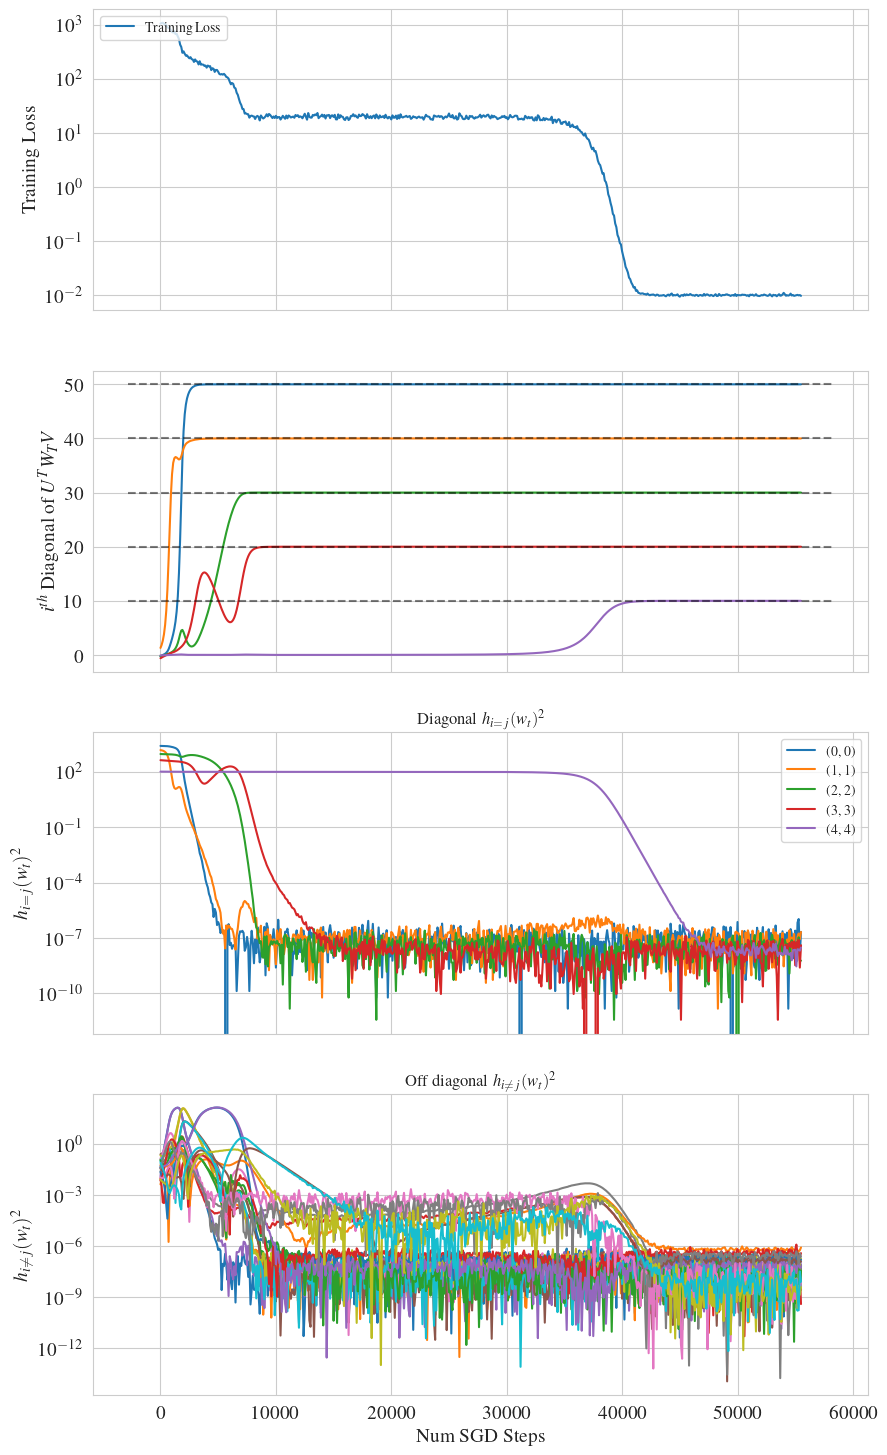

In [4]:
df = df_sgd
# df = df[df["t"] > 10]
df["corrected_total_matrix_diagonals"] = df["corrected_total_matrix"].apply(
    # lambda x: np.linalg.svd(x)[1]
    lambda x: np.diag(x)
)

fig, axes = plt.subplots(4, 1, figsize=(10, 18), sharex=True)
ax = axes[0]
ax.plot(df["t"], df["train_loss"], label="Training Loss")
ax.set_ylabel("Training Loss")
ax.legend(loc="upper left")
ax.set_yscale("log")

if do_llc_estimation:
    ax = ax.twinx()
    clipped_llc = np.clip(df["lambdahat"], a_min=0, a_max=1e6)
    ax.plot(df["t"], clipped_llc, "kx", alpha=0.3, label="Estimated LLC, $\hat{\lambda}(w^*)$")
    yvals = running_mean(clipped_llc)
    ax.plot(df["t"], yvals, "g-")
    stage_llcs = np.array(df["stage_potential_llcs"].tolist())
    stage_llcs = np.clip(stage_llcs, a_min=0, a_max=100)
    for i in range(stage_llcs.shape[1]):
        yvals = running_mean(stage_llcs[:, i])
        ax.plot(df["t"], yvals, label=f"Stage {i + 1}", alpha=0.5)
    ax.set_ylabel("Estimated LLC, $\hat{\lambda}(w^*)$")
    ax.legend(loc="upper right")



ax = axes[1]
key = "corrected_total_matrix_diagonals"
for i in range(min(input_dim, output_dim)):
    ax.plot(
        df["t"],
        df[key].apply(lambda x: x[i]), 
        label="$s_{" + str(i + 1) + "}$"
    )

xmin, xmax = ax.get_xlim()
singvals_true = S
ax.hlines(singvals_true, xmin, xmax, color="k", linestyle="--", alpha=0.5)
ax.set_ylabel("$i^{th}$ Diagonal of $U^T W_T V$")



ax = axes[2]
for i in range(input_output_correlation_matrix.shape[0]):
    yvals = df["potential_matrix"].apply(lambda x: np.array(x)[i, i]**2)
    ax.plot(df["t"], yvals, label=f"({i}, {i})")
ax.set_ylabel("$h_{i=j}(w_t)^2$")
ax.set_title("Diagonal $h_{i=j}(w_t)^2$")
ax.legend()
ax.set_yscale("log")

ax = axes[3]
for i in range(input_output_correlation_matrix.shape[0]):
    for j in range(input_output_correlation_matrix.shape[1]):
        if i == j: continue # only plot the off diagonal elements
        yvals = df["potential_matrix"].apply(lambda x: np.array(x)[i, j]**2)
        ax.plot(df["t"], yvals, label=f"({i}, {j})")
ax.set_ylabel("$h_{i \\neq j}(w_t)^2$")
ax.set_title("Off diagonal $h_{i \\neq j}(w_t)^2$")
ax.set_yscale("log")
# ax.legend()



for i, ax in enumerate(axes): 
    if i == len(axes) - 1:
        ax.set_xlabel("Num SGD Steps")
    # ax.set_yscale("log")
    # ax.set_xscale("log")


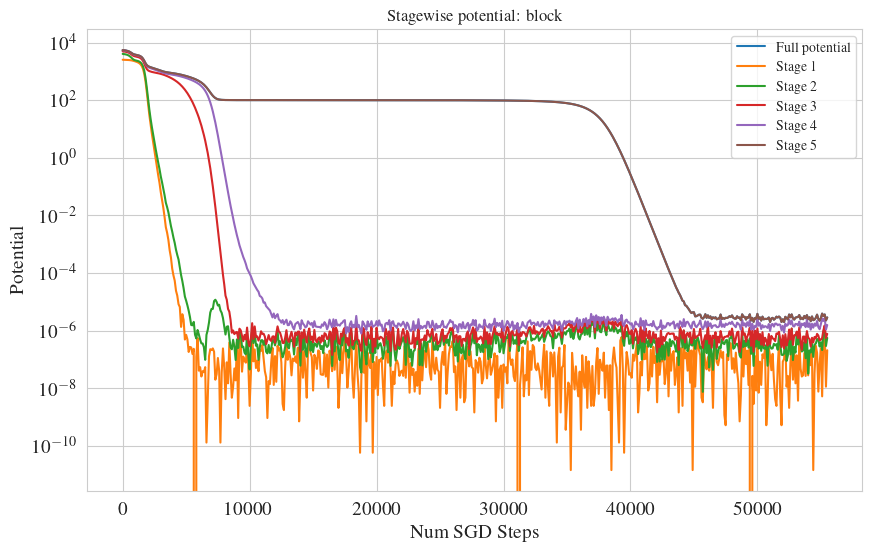

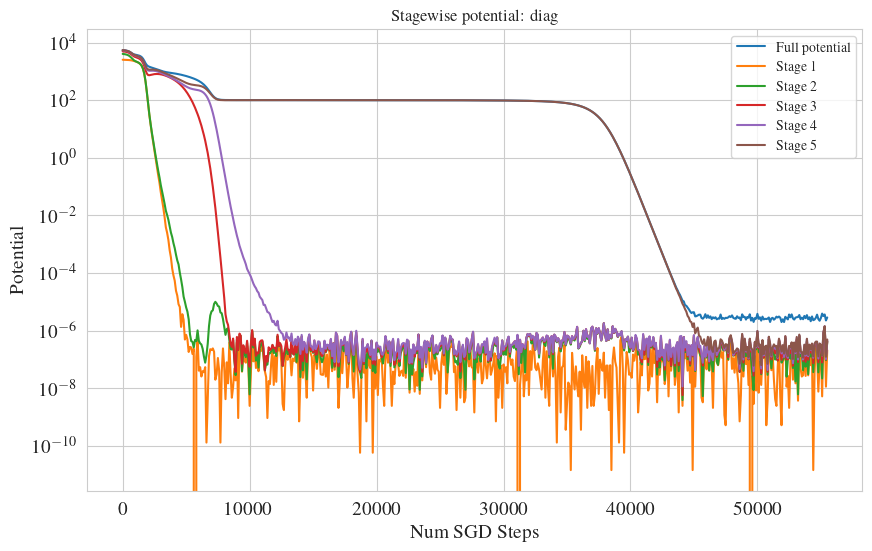

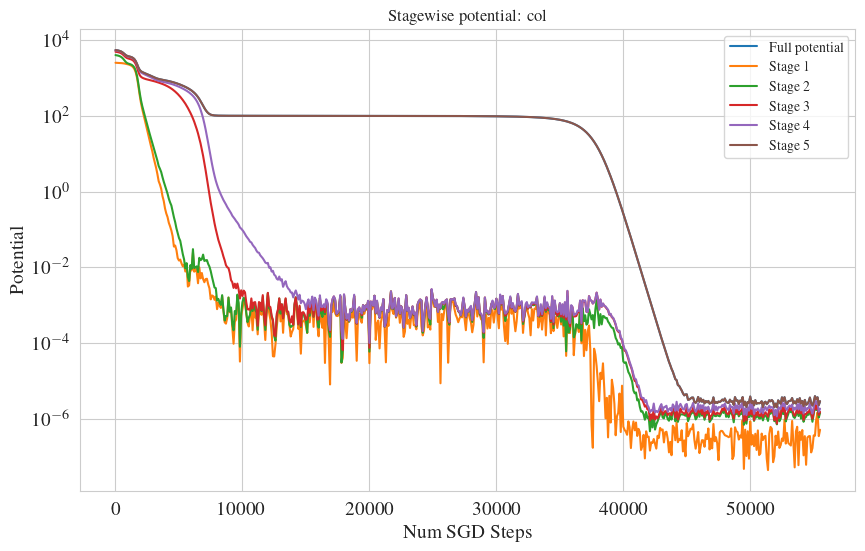

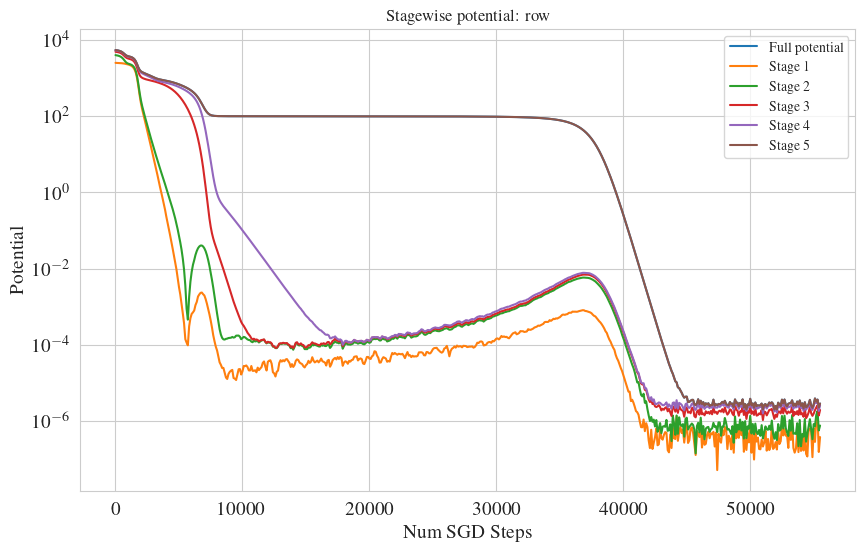

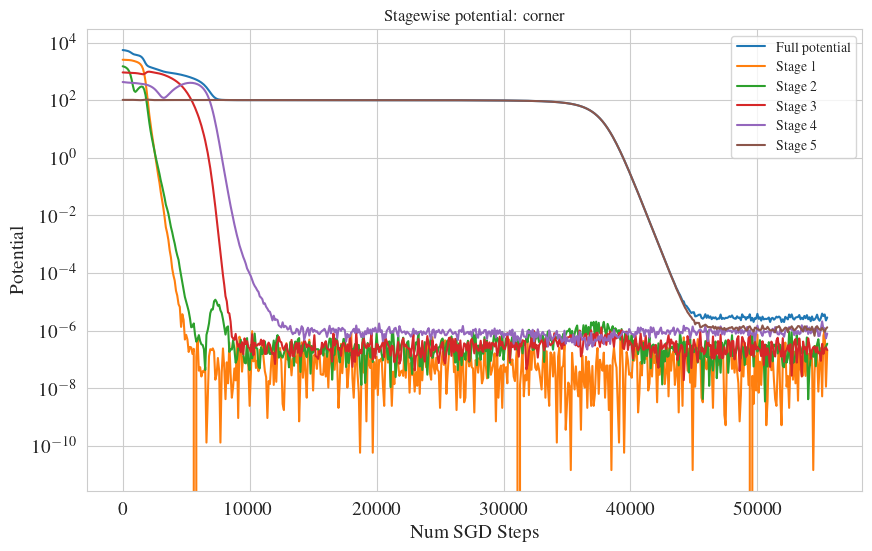

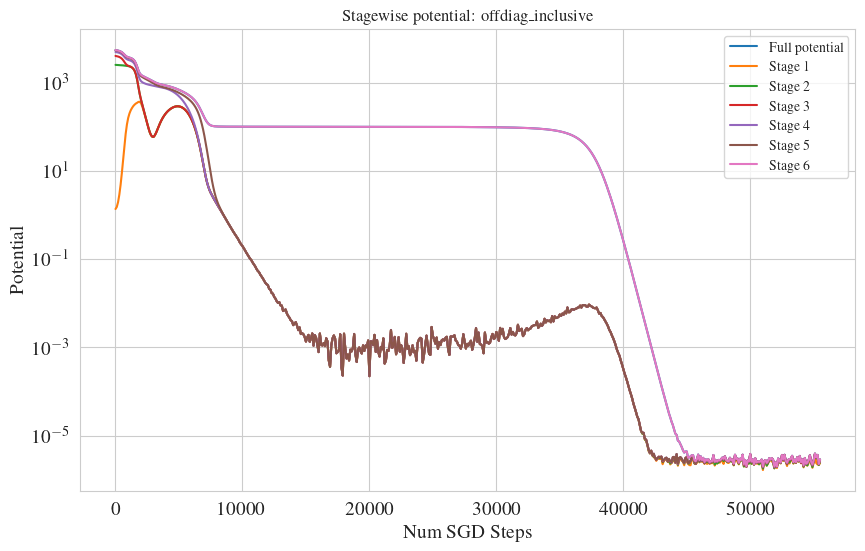

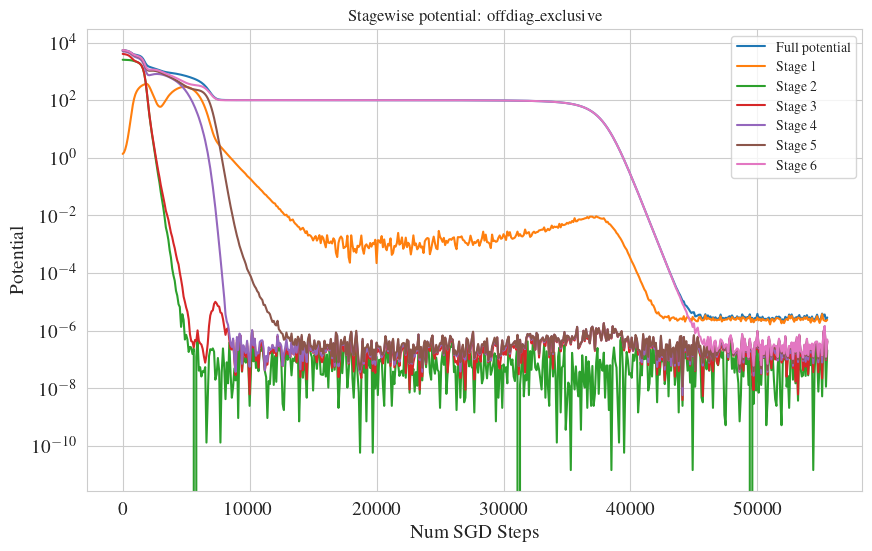

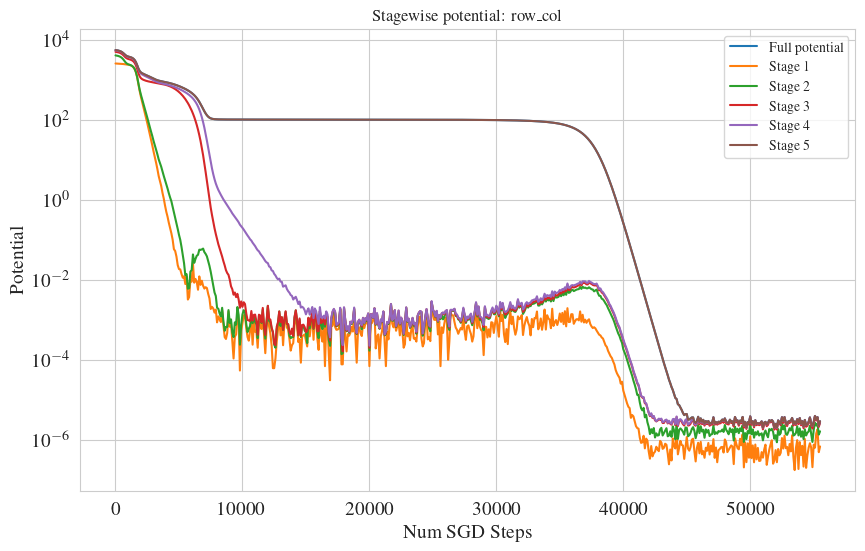

In [5]:
df = df_sgd
cols = [col for col in df.columns if col.startswith("stage_potential")]
ymin_bound = 1e-4
for col in cols:
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.plot(df["t"], df["full_potential"], label="Full potential")
    values = np.array(df[col].tolist())
    # values = np.clip(values, a_min=ymin_bound, a_max=np.inf)
    name = col.split('=')[-1]
    for stage in range(values.shape[1]):
        ax.plot(df["t"], values[:, stage], label=f"Stage {stage + 1}")
    ax.set_xlabel("Num SGD Steps")
    ax.set_ylabel("Potential")
    ax.set_yscale("log")
    ax.legend()
    ax.set_title(f"Stagewise potential: {name}")

# GD Training

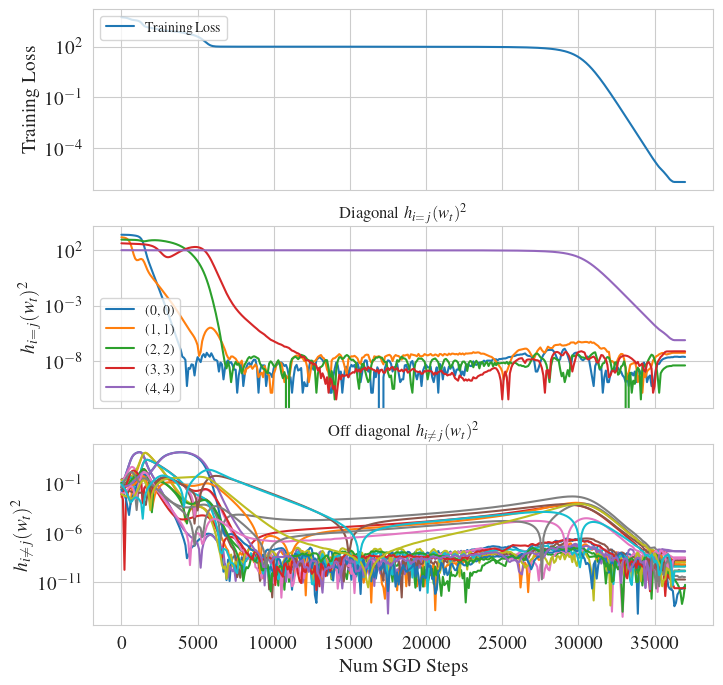

In [12]:
df = df_gd


fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)
ax = axes[0]
ax.plot(df["t"], df["loss"], label="Training Loss")
ax.set_ylabel("Training Loss")
ax.legend(loc="upper left")
ax.set_yscale("log")

# ax = axes[1]
# key = "corrected_total_matrix_diagonals"
# for i in range(min(input_dim, output_dim)):
#     ax.plot(
#         df["t"],
#         df[key].apply(lambda x: x[i]), 
#         label="$s_{" + str(i + 1) + "}$"
#     )

# xmin, xmax = ax.get_xlim()
# singvals_true = S
# ax.hlines(singvals_true, xmin, xmax, color="k", linestyle="--", alpha=0.5)
# ax.set_ylabel("$i^{th}$ Diagonal of $U^T W_T V$")



ax = axes[1]
for i in range(input_output_correlation_matrix.shape[0]):
    yvals = df["potential_matrix"].apply(lambda x: np.array(x)[i, i]**2)
    ax.plot(df["t"], yvals, label=f"({i}, {i})")
ax.set_ylabel("$h_{i=j}(w_t)^2$")
ax.set_title("Diagonal $h_{i=j}(w_t)^2$")
ax.legend()
ax.set_yscale("log")

ax = axes[2]
for i in range(input_output_correlation_matrix.shape[0]):
    for j in range(input_output_correlation_matrix.shape[1]):
        if i == j: continue # only plot the off diagonal elements
        yvals = df["potential_matrix"].apply(lambda x: np.array(x)[i, j]**2)
        ax.plot(df["t"], yvals, label=f"({i}, {j})")
ax.set_ylabel("$h_{i \\neq j}(w_t)^2$")
ax.set_title("Off diagonal $h_{i \\neq j}(w_t)^2$")
ax.set_yscale("log")
# ax.legend()



for i, ax in enumerate(axes): 
    if i == len(axes) - 1:
        ax.set_xlabel("Num SGD Steps")

# Stagewise Training

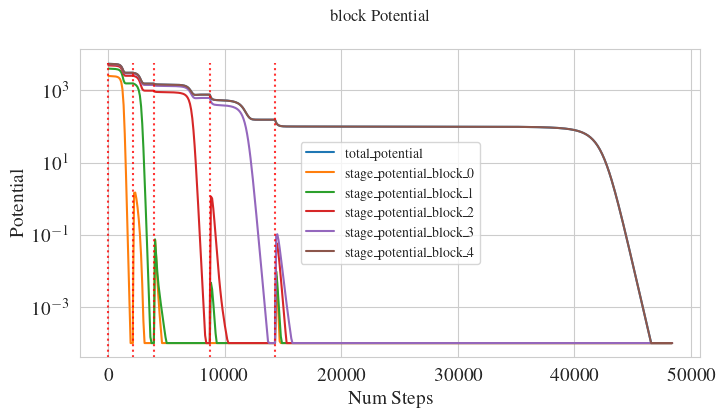

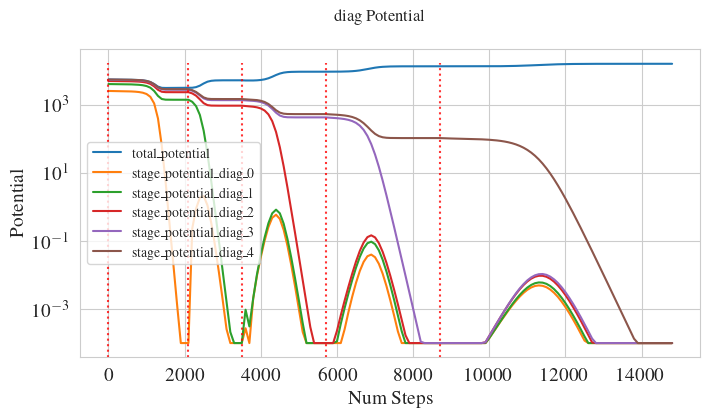

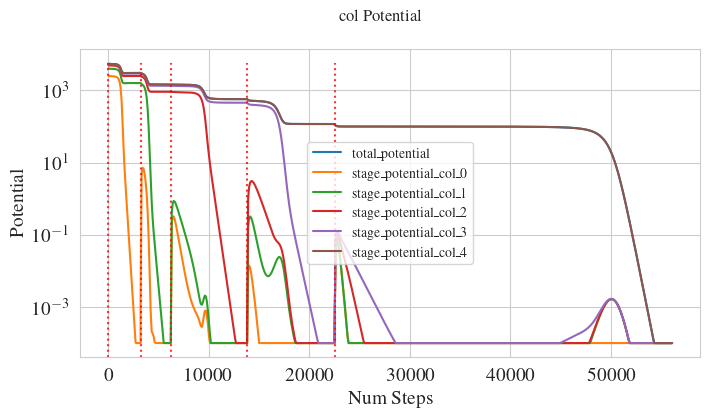

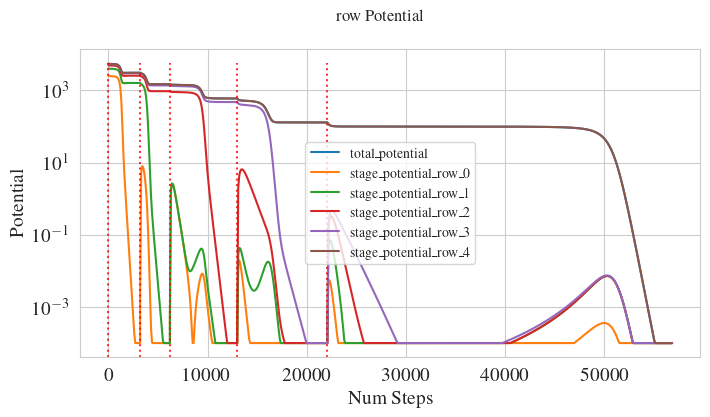

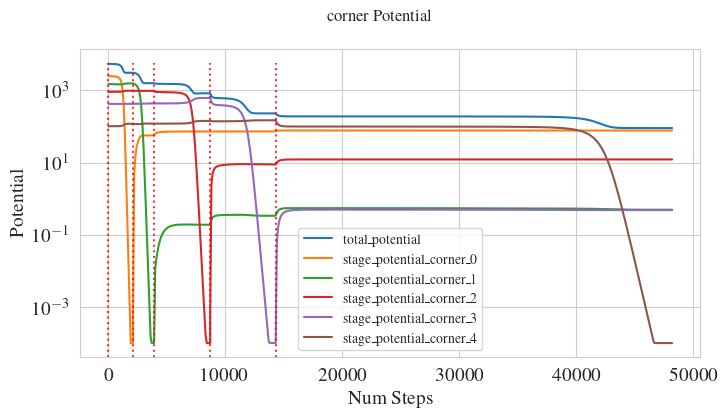

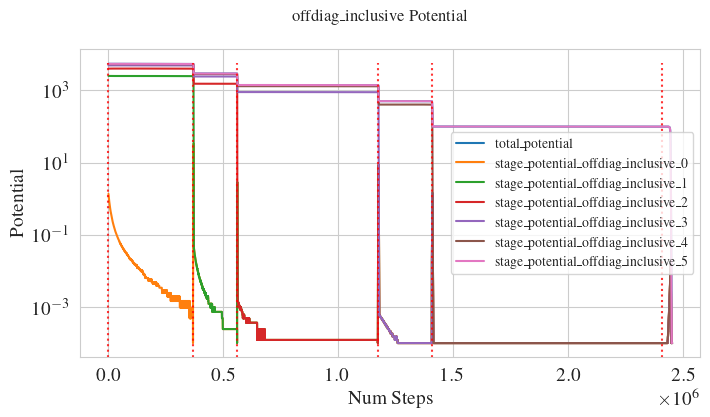

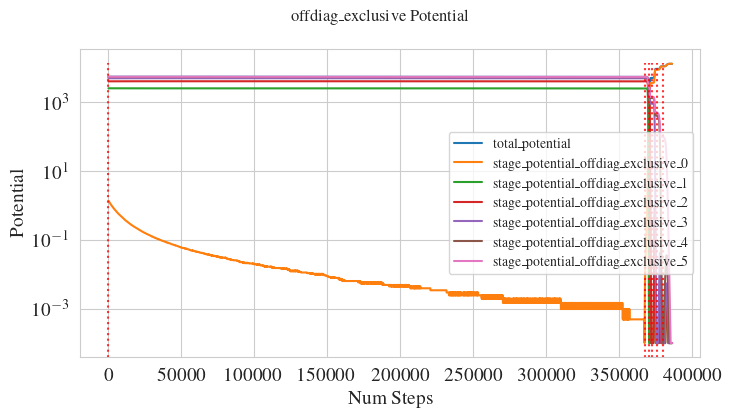

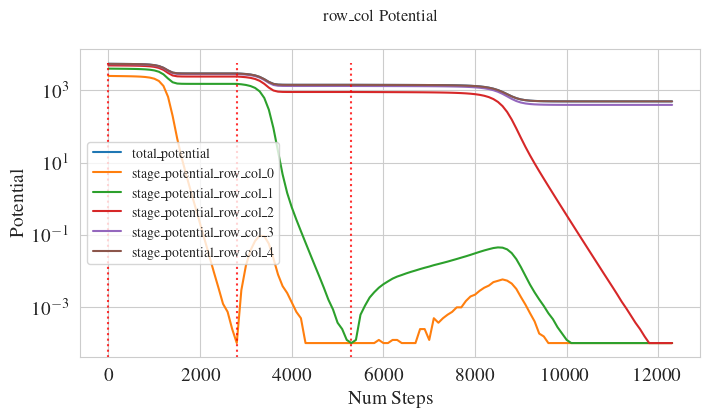

In [13]:
ymin_bound = 1e-4
# ymin_bound = -np.inf
for potential_type, df in stagewise_dfs.items():
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    cols = ["total_potential"] + [col for col in df.columns if col.startswith("stage_potential")]
    for col in cols:
        yvals = np.clip(df[col], a_min=ymin_bound, a_max=np.inf)
        ax.plot(df["total_time"], yvals, label=col)

    stage_boundaries = df.groupby("stage")["total_time"].min().values
    ymin, ymax = ax.get_ylim()
    ax.vlines(stage_boundaries, ymin, ymax, color="r", linestyle="dotted", alpha=0.8)

    ax.set_xlabel("Num Steps")
    ax.set_ylabel("Potential")

    ax.set_yscale("log")
    # ax.set_xscale("log")
    ax.legend()
    fig.suptitle(f"`{potential_type}` Potential")